<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/reinforcement_learning/examples/reinforcement_learning/tabular/actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this final algorithm, the only additional object we need to define is the algorithm itself. First we again reuse code from earlier notebooks.

In [0]:
#@title
class excursions(object):
	"""A simple environment which provides rewards based on excursions."""

	def __init__(self, parameters):
		self.trajectory_length = parameters['trajectory_length']
		self.positivity_bias = parameters['positivity_bias']
		self.target_bias = parameters['target_bias']
		self.action = 0
		self.state = [0, 0]
		self.terminal_state = False

	def _reward(self):
		"""Calculates the reward for the last transition to occur."""
		if self.state[0] < 0:
			reward = -self.positivity_bias * abs(self.state[0])
		else:
			reward = 0
		if self.state[1] == self.trajectory_length:
			reward -= self.target_bias * abs(self.state[0])
		return reward

	def step(self, action):
		"""Updates the environment state based on the input action."""
		self.action = action
		self.state[0] += 2*action - 1
		self.state[1] += 1
		if self.state[1] == self.trajectory_length:
			self.terminal_state = True
		return self.state, self._reward(), self.terminal_state

	def reset(self):
		"""Resets the environment state and terminal boolean."""
		self.action = 0
		self.state = [0, 0]
		self.terminal_state = False


class two_action_policy_table(object):
	"""A tabular policy for environments where each state has two actions."""

	def __init__(self, dimensions, learning_rate):
		self.table = np.zeros(dimensions)
		self.learning_rate = learning_rate

	def _forward(self, state):
		"""Calculates the probabilitiy of action 1."""
		exponentiated_potential = math.exp(-self.table[state[0]][state[1]])
		return 1/(exponentiated_potential+1)

	def action(self, state):
		"""Returns a random action according to the current policy."""
		action1_probability = self._forward(state)
		random = numpy.random.random()
		if random < action1_probability:
			return 1, 1 - action1_probability
		else:
			return 0, -action1_probability
	
	def step(self, state, error, eligibility):
		"""Updates the potential for actions in the given state."""
		self.table[state[0]][state[1]] += self.learning_rate * error * eligibility


class value_table(object):
	"""A generic tabular state value function."""

	def __init__(self, dimensions, learning_rate):
		self.table = np.zeros(dimensions)
		self.learning_rate = learning_rate

	def forward(self, state):
		"""Returns the value of the specified state."""
		return self.table[state[0]][state[1]]

	def step(self, state, error):
		"""Updates the value of the specified state."""
		self.table[state[0]][state[1]] += self.learning_rate * error


class episodic_algorithm(object):
	"""A wrapper for episodic RL algorithms."""

	def __init__(self, parameters):
		self.environment = parameters['environment']
		self.average_return = 0
		self.average_returns = []
		self.returns = []
		self.return_learning_rate = parameters['return_learning_rate']
		self.policy = parameters['policy']
		self.episode = 0
		self.past_state = self.environment.state.copy()
		self.action = 0
		self.current_state = self.environment.state.copy()
		self.reward = 0
		self.current_return = 0
		self.terminal_state = False
	
	def _transition(self):
		"""Requests an action from the policy and sends it to the environment."""
		self.past_state = self.current_state.copy()
		self.action, self.eligibility = self.policy.action(self.current_state)
		self.current_state, self.reward, self.terminal_state = self.environment.step(
			self.action)
		self.current_return += self.reward

	def _per_step(self):
		"""A placeholder for a learning algorithms computations per transition."""
		self._transition()

	def _per_episode(self):
		"""A placeholder for a learning algorithms computations after episodes."""
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False

	def _episode(self):
		"""Uses _per_step and _per_episode to run a generic episodes computations."""
		self.current_return = 0
		while not self.terminal_state:
			self._per_step()
		self._per_episode()
		self.average_return += self.return_learning_rate * (self.current_return 
															- self.average_return)
		self.episode += 1

	def train(self, episodes):
		"""Trains the policy by repeatedly running episodes, storing return info."""
		self.episode = 0
		while self.episode < episodes:
			self._episode()
			self.average_returns.append(self.average_return)
			self.returns.append(self.current_return)

	def _sample(self):
		"""Generates a sample trajectory using the current policy."""
		self.current_return = 0
		trajectory = [self.current_state.copy()]
		while not self.terminal_state:
			self._transition()
			trajectory.append(self.current_state.copy())
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False
		return trajectory

	def samples(self, sample_count):
		"""Generates a set of trajectory samples."""
		trajectories = []
		sample = 0
		while sample < sample_count:
			trajectory = self._sample()
			trajectories.append(trajectory)
			sample += 1
		return trajectories

	def _return_sample(self):
		"""Runs an episode to sample a return for evaulation."""
		self.current_return = 0
		while not self.terminal_state:
			self._transition()
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False

	def evaluate(self, sample_count, set_average = True):
		"""Evaluates the policy by estimating the average return."""
		sample = 1
		average_return = 0
		while sample <= sample_count:
			self._return_sample()
			average_return += (self.current_return - average_return)/sample
			sample += 1
		if set_average:
			self.average_return = average_return
		return average_return


class monte_carlo_returns(episodic_algorithm):
	"""A purely return based policy gradient algorithm."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.states = []
		self.rewards = []
		self.eligibilities = []

	def _per_step(self):
		"""Adds required data storage for learning post-episode."""
		self._transition()
		self.states.append(self.past_state)
		self.rewards.append(self.reward)
		self.eligibilities.append(self.eligibility)

	def _update(self):
		"""Loops over the episode in reverse, updating the policy in each state."""
		self.rewards = np.array(self.rewards)
		state_return = 0
		for index in range(len(self.states) - 1, -1, -1):
			state_return += self.rewards[index]
			self.policy.step(self.states[index], state_return, self.eligibilities[index])

	def _per_episode(self):
		"""Adds additional resets relevant to learning algorithm."""
		self._update()
		super()._per_episode()
		self.states = []
		self.rewards = []
		self.eligibilities = []


class monte_carlo_value_baseline(monte_carlo_returns):
	"""Contrasts returns with estimated values for policy updates."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.values = parameters['values']
		self.state_values = []

	def _per_step(self):
		"""Adds required data storage for learning post-episode."""
		super()._per_step()
		self.state_values.append(self.values.forward(self.past_state))

	def _update(self):
		"""Loops over the episode in reverse, updating state policies and values."""
		self.rewards = np.array(self.rewards)
		state_return = 0
		for index in range(len(self.states) - 1, -1, -1):
			state_return += self.rewards[index]
			error = state_return - self.state_values[index]
			self.policy.step(self.states[index], error, self.eligibilities[index])
			self.values.step(self.states[index], error)

	def _per_episode(self):
		"""Adds additional resets relevant to learning algorithm."""
		super()._per_episode()
		self.state_values = []

The new algorithm is particularly simple: we inherit most of the structure from the base episodic_algorithm class, modifying the _per_step function to update the policy and value of the state prior to the current transition, using the value of the state after and the reward in between.

In [0]:
class actor_critic(episodic_algorithm):
	"""Uses the value as a baseline and an estimate of future returns."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.values = parameters['values']

	def _update(self):
		"""Updates the policy and value for the previous state."""
		past_value = self.values.forward(self.past_state)
		current_value = self.values.forward(self.current_state)
		td_error = current_value + self.reward - past_value
		self.values.step(self.past_state, td_error)
		self.policy.step(self.past_state, td_error, self.eligibility)

	def _per_step(self):
		"""Overrides the _per_step method, to transition and update each step."""
		self._transition()
		self._update()

For testing, we again initialize the environment, tables, and now three agents using the three algorithms discussed.

In [0]:
environment_parameters = dict(
	trajectory_length = 20, 
	positivity_bias = 1,
	target_bias = 2,
)
environment = excursions(environment_parameters)

table_dimension = (environment_parameters['trajectory_length']*2 + 1, 
				   environment_parameters['trajectory_length'] + 1)
policy1 = two_action_policy_table(table_dimension, 0.15)
values2 = value_table(table_dimension, 0.6)
policy2 = two_action_policy_table(table_dimension, 0.15)
values3 = value_table(table_dimension, 0.6)
policy3 = two_action_policy_table(table_dimension, 0.15)

algorithm_parameters1 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	policy = policy1,
)
algorithm_parameters2 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	values = values2,
	policy = policy2,
)
algorithm_parameters3 = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	values = values3,
	policy = policy3,
)
agent1 = monte_carlo_returns(algorithm_parameters1)
agent2 = monte_carlo_value_baseline(algorithm_parameters2)
agent3 = actor_critic(algorithm_parameters3)

We then follow the same procedure as the previous notebooks, starting with evaluation of the initial policy.

Initial return: -32.66800000000002


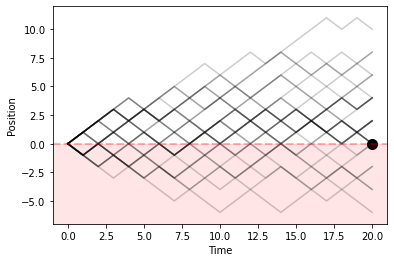

In [6]:
from matplotlib import pyplot as plt

initial_return = agent1.evaluate(1000)
agent2.average_return = initial_return
agent3.average_return = initial_return
print("Initial return: %s"%(initial_return))
initial_samples = agent1.samples(30)

min_y = np.min(np.array(initial_samples)[:,:,0]) - 1
max_y = np.max(np.array(initial_samples)[:,:,0]) + 1

plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 100)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

Next we train all three agents, plotting their returns.

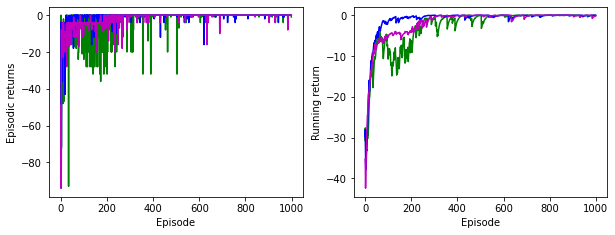

In [7]:
episodes = 1000
agent1.train(episodes)
agent2.train(episodes)
agent3.train(episodes)

plt.figure(figsize = (10, 3.5))
plt.subplot(121)
plt.plot(agent3.returns, c = 'g')
plt.plot(agent1.returns, c = 'b')
plt.plot(agent2.returns, c = 'm')
plt.xlabel("Episode")
plt.ylabel("Episodic returns")
plt.subplot(122)
plt.plot(agent3.average_returns, c = 'g')
plt.plot(agent1.average_returns, c = 'b')
plt.plot(agent2.average_returns, c = 'm')
plt.xlabel("Episode")
plt.ylabel("Running return")
plt.show()

Finally, we once again compare these resulting policies with the initial one.

Initial return: -32.66800000000002, agent1's final return: -0.06599999999999996, agent2's final return: -0.13200000000000003, agent3's final return: -0.16899999999999973


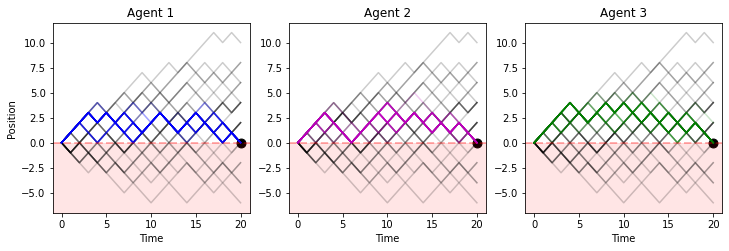

In [8]:
final_return1 = agent1.evaluate(1000)
final_return2 = agent2.evaluate(1000)
final_return3 = agent3.evaluate(1000)
print("Initial return: %s, agent1's final return: %s, agent2's final return: %s, agent3's final return: %s"
%(initial_return, final_return1, final_return2, final_return3))
samples1 = agent1.samples(30)
samples2 = agent2.samples(30)
samples3 = agent3.samples(30)

plt.figure(figsize = (12, 3.5))
plt.subplot(131)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples1)[:,:,0].T, c = 'b', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 1")
plt.xlabel("Time")
plt.ylabel("Position")
plt.subplot(132)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples2)[:,:,0].T, c = 'm', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 2")
plt.xlabel("Time")
plt.subplot(133)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples3)[:,:,0].T, c = 'g', alpha = 0.2)
plt.scatter([20], [0], c = 'k', marker = 'o', s = 80)
plt.plot([-1, 21], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, 21], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, 21)
plt.ylim(min_y, max_y)
plt.title("Agent 3")
plt.xlabel("Time")

plt.show()